In [426]:
# Data Manipulation & Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (RandomizedSearchCV, GridSearchCV)
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Linear Regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols

# Reading Data, Inspect Data, Remain Meaningful Columns

In [434]:
df = pd.read_csv('CO2_emissions.csv', engine='python')
df = df.rename(columns={'Fuel_Consumption_comb(L/100km)':'total_fuel_consumption'})
df = df[['Engine_Size', 'Cylinders', 'total_fuel_consumption', 'Smog_Level']]

X = df[['Engine_Size', 'Cylinders', 'total_fuel_consumption']]
y = df.Smog_Level
# X
# df

## Train Test Split

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

## Plot the distribution of residual of the data

Use subplot to plot 3 figures of disribution of the residual of Engine_Size, Cylinders, total_fuel_consumption

In [447]:
model = sm.OLS(y, sm.add_constant(X)).fit()
X_pred = model.predict(sm.add_constant(X))
print(model.summary())
# sns.histplot(model.resid, bins=20)

                            OLS Regression Results                            
Dep. Variable:             Smog_Level   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     150.7
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           1.38e-79
Time:                        16:27:34   Log-Likelihood:                -1644.0
No. Observations:                 935   AIC:                             3296.
Df Residuals:                     931   BIC:                             3315.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

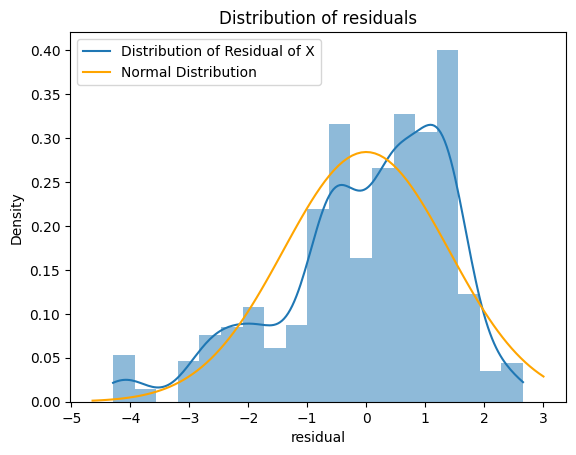

In [448]:
fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")


mu, std = stats.norm.fit(model.resid)
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.legend(['Distribution of Residual of X', 'Normal Distribution'])
plt.savefig('distribution.png')
plt.show()

# KNN & Graphing + CV + Best Parameter & Clustering graphing

In [173]:
# grid search 
# Dont run this code, laggy...
kNN = KNeighborsClassifier()

p_param = list(range(1,11))
n_neighbors_param = list(range(1,1000))
hyperparameters = {'n_neighbors':n_neighbors_param, 'weights':('uniform', 'distance'), 'p':p_param}

start = time.time()
clf = GridSearchCV(kNN, hyperparameters, n_jobs=-1)
clf.fit(X, y)
end = time.time()
print(f'Time consumed: {end-start:.3}')
print(f'clf.best_score_={clf.best_score_:.3}, clf.best_params_={clf.best_params_}')

Time consumed: 3.19e+02
clf.best_score_=0.507, clf.best_params_={'n_neighbors': 272, 'p': 3, 'weights': 'distance'}


D:\python\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.44385027 0.44385027 0.44812834 ...        nan        nan        nan]
  warnings.warn(


p ranges 1 to 10, n_neighbors ranges 1, 1000. clf.best_score_=0.507, clf.best_params_={'n_neighbors': 272, 'p': 3, 'weights': 'distance'}

In [437]:
kNN = KNeighborsClassifier(n_neighbors=272, p=3, weights='distance')
kNN.fit(X_train, y_train)
knn_score = kNN.score(X_test, y_test)
print(f'Training Accuracy: {kNN.score(X_train, y_train):.3}')
print(f'Test Accuracy: {kNN.score(X_test, y_test):.3}')

Training Accuracy: 0.817
Test Accuracy: 0.585


# PCA Dimensionality Reduction to increase the accuracy

In [417]:
pca = PCA(n_components=2, random_state=0)
pca.fit(X)
X_new = pca.transform(X)
# print(X_new)

p_param = list(range(1,11))
n_neighbors_param = list(range(1,500))
hyperparameters = {'n_neighbors':n_neighbors_param, 'weights':('uniform', 'distance'), 'p':p_param}
start = time.time()
clf = GridSearchCV(kNN, hyperparameters, n_jobs=-1)
clf.fit(X_new, y)
end = time.time()
print(f'Time consumed: {end-start:.3}')
print(f'clf.best_score_={clf.best_score_:.3}, clf.best_params_={clf.best_params_}')

In [444]:
# PCA dimensionality reduction to increase the accuracy
pca = PCA(n_components=2, random_state=0)
pca.fit(X)
X_new = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0, stratify=y)
# 272 p=3 distance before dimensionality reduction using grid search
kNN_reduced = KNeighborsClassifier(n_neighbors=211, p=2, weights='distance')
kNN_reduced.fit(X_train, y_train)
knn_reducedDim_score = kNN_reduced.score(X_test, y_test)
# print(kNN_reduced.score(X_train, y_train))
print(round(knn_reducedDim_score,3))


0.62


## Plot 2D reduced dimensionality graph

D:\python\lib\site-packages\mlxtend\plotting\decision_regions.py:300: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


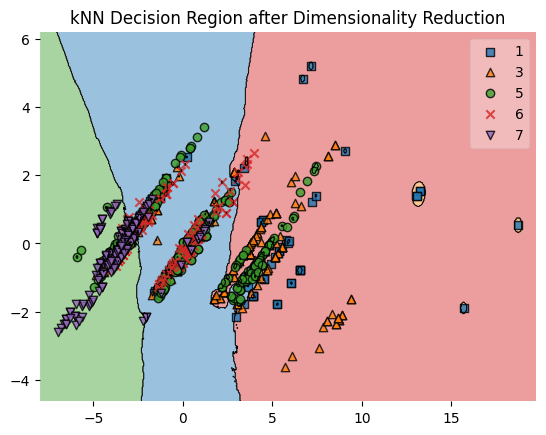

In [274]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X=X_new, y=y.to_numpy(), clf=kNN)
plt.title('kNN Decision Region after Dimensionality Reduction')
plt.savefig('knnReduced.png')

In [267]:
# df.groupby('Smog_Level').describe()

## KMeans Clustering 3D Visualization

In [232]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

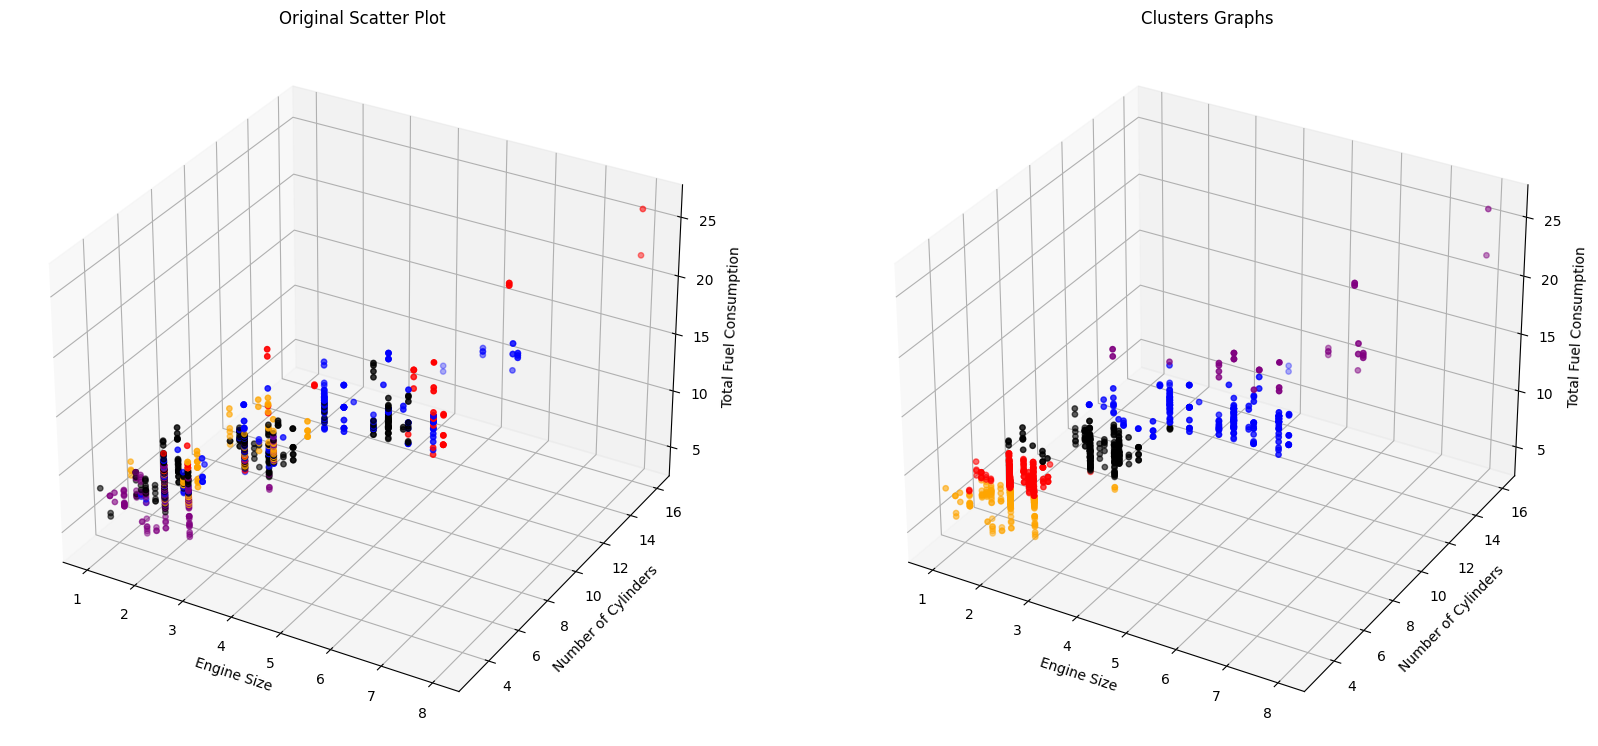

In [378]:
df_new = df[['Engine_Size', 'Cylinders', 'total_fuel_consumption', 'Smog_Level']]
# X.groupby('cluster').describe()
colors = ['red', 'blue', 'black', 'orange', 'purple']
df_new['c'] = df_new.Smog_Level.map({1:colors[0], 3:colors[1], 5:colors[2], 6:colors[3], 7:colors[4]})

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df_new.Engine_Size, df_new.Cylinders, df_new.total_fuel_consumption, c=df_new.c, s=15)
ax.set_title('Original Scatter Plot')
ax.set_xlabel('Engine Size')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Total Fuel Consumption')
# plt.savefig('3D_KNN.png')

X = df[['Engine_Size', 'Cylinders', 'total_fuel_consumption']]

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.predict(X)
X = df[['Engine_Size', 'Cylinders', 'total_fuel_consumption', 'cluster']]
# X.groupby('cluster').describe()
colors = ['red', 'blue', 'black', 'orange', 'purple']
X['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4]})

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X.Engine_Size, X.Cylinders, X.total_fuel_consumption, c=X.c, s=15)
ax.set_title('Clusters Graphs')
ax.set_xlabel('Engine Size')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Total Fuel Consumption')
plt.savefig('Comparison.png')
plt.show()